# QUBO formulation of the Redundant Calibration

In [1]:
from dwave.system import DWaveSampler , EmbeddingComposite
import neal
from dimod import ExactSolver
import math
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qubo_redcal_utils import get_antnennas_response
from create_qubo_matrix import SolutionVector, create_qubo_matrix

## 1. Redundant Calibration

We consider here the case of 5 antennas that are positionned in a row. The positions of the antennas are given by :

In [2]:
n_ant = 5
xpos = np.linspace(-2, 2, n_ant)[:,None]

The magnitude matrix is in this case given by :

In [3]:
Mmag = np.matrix(
    [[1, 1, 0, 0, 0, 1, 0, 0],     # baseline type 1 (4 rows)
     [0, 1, 1, 0, 0, 1, 0, 0],
     [0, 0, 1, 1, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 1, 0, 0],
     [1, 0, 1, 0, 0, 0, 1, 0],     # baseline type 2 (3 rows)
     [0, 1, 0, 1, 0, 0, 1, 0],
     [0, 0, 1, 0, 1, 0, 1, 0],
     [1, 0, 0, 1, 0, 0, 0, 1],     # baseline type 3 (2 row)
     [0, 1, 0, 0, 1, 0, 0, 1],
     [1, 0, 0, 0, 0, 0, 0, 0]])    # magnitude constraint

The redundant calibration is then reduced to solving the least square problem [https://arxiv.org/pdf/1004.0156.pdf]

$$
M_{mag} \theta = b
$$

where $b$ is given by the response of the antennas. For convenience we have packaged that response in a small method 

In [4]:
b = get_antnennas_response(xpos)

## Classical Solution

The solution of such a small system can be obtained by a least square as implemented in numpy

In [5]:
npsol = np.linalg.lstsq(Mmag,b, rcond=None)
npsol = np.asarray(npsol[0]).flatten()


## 2. QUBO formalism for linear systems

The Quandratic Unconstrainted Binary Optimization problem, or QUBO, allows to minimize the cost function :

$$
E(x) = x^{T}Qx
$$

where the variables $x_i$ are binaries, i.e. the are 0 or 1. The equation above can be rewritten as :

$$
E(x) = \sum_i Q_{ii}x_i + \sum_{ij} Q_{ij}x_ix_j
$$

that is very similar to the Ising model, basis of the quantum annealler architecture. 

### Encoding real numbers in binary variables

In the QUBO problems, variables are binaries and we of course want to solve for real numbers in our case. There ar e different ways to encode real numbers in multiple binaries. In our case since the variables are between -1.0 and 1.0 we can use the following encoding : 

$$
r_i = a \sum_n x_n 2^{n} - x_{k+n} 2^{n} 
$$

where $a$ is a normalization constant. THis encoding is created in the `SolutionVector` class that allows to encode/decode real numbers in a series of binaries variables. We use here the `RealUnitQbitEncoding` to obtain real numbers between -1 and 1. The number of qbit controls the precision of the reals we can obtain.

In [8]:
from create_qubo_matrix import RealUnitQbitEncoding

sol = SolutionVector(size=Mmag.shape[1], nqbit=10, encoding=RealUnitQbitEncoding)
x = sol.create_polynom_vector()

### Linear systems

To solve a linear system $Ax=b$ with QUBO we need to minimize the following loss 

$$
E(x) = ||Ax-b||^2 =(Ax-b)^T (Ax-b) = x^T A^T A x-b^T A x-A x b^T+ b^T b = x^T Q x + ||b||^2
$$

We can ignore the last terms as it doesn't contribute to the optimization process. The $Q$ matrix can be defined through the different terms of the expression. This is achieved by the `create_qubo_matrix` methods that returns a `dict` containing the weights (diagonal terms) and strengths (off diagonal terms) of the $Q$ matrix. 

In [9]:
qubo_dict = create_qubo_matrix(Mmag, b, x)

## 3. Solving the system

We will use here the `SimulatedAnnealingSampler` to be able to run that code locally. Quantum solvers are available through the Leap cloud service.

In [10]:
sampler = neal.SimulatedAnnealingSampler()

In [35]:
sampleset = sampler.sample_qubo(qubo_dict,num_reads=1000)
lowest_sol = sampleset.lowest()
sol_num = sol.decode_solution(lowest_sol.record[0][0])

In [36]:
print(sol_num)

[ 0.         -0.12903226 -0.12903226 -0.06451613  0.          0.09677419
  0.25806452  0.61290323]


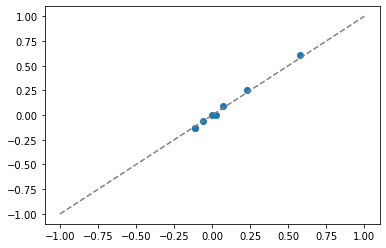

In [40]:
plt.scatter(npsol, sol_num)
plt.plot([-1,1],[-1,1],'--',c='gray')